In [22]:
import numpy as np
import pandas as pd
import os

class ModelData:
    def __init__(self):
        self.name = None
        self.seed = None
        self.run = None
        self.gem = None
        self.gem_id = None
        self.pos = None
        self.people = None
        self.phases = None
        self.status = None
        self.timestep = None

        self.exposed = None
        self.infected = None
        self.recovered = None
        self.hospital = None

# Load data
def load_data(seed, run, intervention):
    path = os.getcwd() + '/Data/Model_V1/Data/'

    data = ModelData()
    data.name = intervention
    data.seed = seed
    data.run = run
    
    data.gem = pd.read_pickle(path + 'Gemeenten.pkl')
    data.gem_id = pd.read_pickle(path +'GemeentenID.pkl')
    data.pos = np.load(path + 'Positions.npy')

    try:
        path = os.getcwd() + '/Data/Model_V1/Data/High/Seed_' + str(seed) + '/'

        data.people = pd.read_pickle(path + 'PeopleDF.pkl')

        data.phases = pd.read_pickle(path + 'Runs_' + intervention + '/Phases_' + str(run) + '.pkl')
        data.status = np.load(path + 'Runs_' + intervention + '/Status_' + str(run) + '.npz')
        data.timestep = np.loadtxt(path + 'Runs_' + intervention + '/Timestep_' + str(run))
    except:
        print("Error loading data ({}, {}, {})".format(intervention, seed, run))
        return

    return data

In [23]:
seeds = [0]
runs = [0]
interventions = ['ref', 'behavior', 'working', 'school']

data_points = []
for seed in seeds:
    for run in runs:
        for intervention in interventions:
            data_points.append(load_data(seed, run, intervention))

data_points = list(filter(None, data_points))
print('Succesfully loaded ' + str(len(data_points)) + ' data points')

Succesfully loaded 4 data points


In [24]:
# Print info for a specific datapoint
data = data_points[0]
print('name: ', data.name)
print('gem: ', data.gem.shape)
print('gem_id: ', data.gem_id.shape)
print('pos: ',data.pos.shape)
print('people: ',data.people.shape)
print(data.status.files)

# timesteps: n_days * 24
print('timesteps: ', data.status['indptr'].shape)
#indices of all people that are infected at timestep t=1000
print('status: ', data.status['indices'][data.status['indptr'][1000] : data.status['indptr'][1001]])
print(data.people['Group'][0])

name:  ref
gem:  (380, 1)
gem_id:  (380, 1)
pos:  (7, 24, 170721)
people:  (170721, 382)
['indices', 'indptr', 'format', 'shape', 'data']
timesteps:  (2881,)
status:  [     8     33    106 ... 170686 170696 170719]
a) Pre-school children


In [32]:
# map containing hospitalisation values per demographic group
p_hos_map = {
    'a) Pre-school children':       0,
    'b) Primary school children':   0,
    'c) Secondary school children': 0.0018,
    'd) Students':                  0.0006,
    'e) Non-studying adolescents':  0.0006,
    'f) Middle-age working':        0.0081,
    'g) Middle-age unemployed':     0.0081,
    'h) Higher-age working':        0.0276,
    'i) Higher-age unemployed':     0.0276,
    'j) Elderly':                   0.0494,
    'k) Eldest':                    0.0641
}

# Compute model data per timestep
for data in data_points:
    timesteps = data.status['indptr'].shape[0] -1
    raw_data = data.status['data']
    indptr = data.status['indptr']
    indices = data.status['indices']

    data.hospital = np.zeros(timesteps)
    data.exposed = np.zeros(timesteps)
    data.infected = np.zeros(timesteps)
    data.recovered = np.zeros(timesteps)

    prev_infected = set()
    for t in range(0, timesteps):
        timestamp_row = raw_data[indptr[t] : indptr[t + 1]]
        infected_mask = timestamp_row == 2
        infected_row = indices[indptr[t] : indptr[t + 1]][infected_mask]
        #print(len(infected_row))

        # get new infected cases a.k.a people that are not in prev_infected
        new_infected = set(infected_row).difference(prev_infected)
        prev_infected = infected_row

        # compute hospitalisations of new cases
        total_hosp = 0
        for i in new_infected:
            total_hosp += p_hos_map[data.people['Group'][i]]

        # assign data to object
        data.hospital[t] = total_hosp
        data.exposed[t] = np.count_nonzero(timestamp_row == 1)
        data.infected[t] = np.count_nonzero(timestamp_row == 2)
        data.recovered[t] = np.count_nonzero(timestamp_row == 3)

# Check some general info
# print(data_points[0].infected.size)
# print(np.argmin(data_points[0].infected))

2880
1859


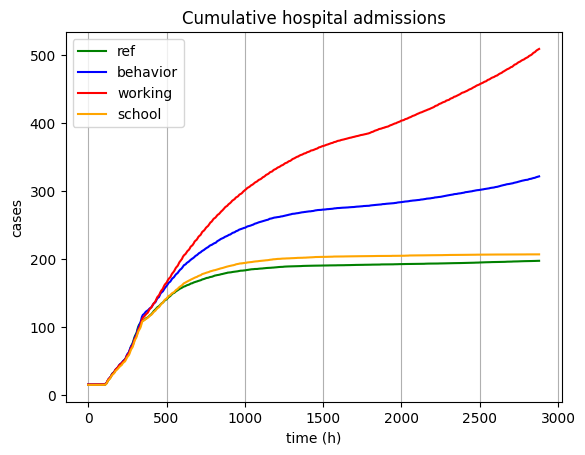

In [35]:
import matplotlib.pyplot as plt

p_hos = 0.01

# For easy comparison to figure 3 of the paper.
color_map = {
    'ref': 'green',
    'school': 'orange',
    'behavior': 'blue',
    'working': 'red'
}

plt.title('Cumulative hospital admissions')
plt.xlabel('time (h)')
plt.ylabel('cases')
#plt.yscale('log')
for data in data_points:
    plt.plot(np.arange(0, len(data.hospital)), np.cumsum(data.hospital), label=data.name, color=color_map[data.name])
plt.grid(axis='x')
#plt.xticks([4*24,11*24, 60*24])
plt.legend()
plt.show()